In [1]:
import pandas as pd
import re
import warnings
from spacy import displacy
warnings.filterwarnings("ignore")

In [28]:
df = pd.read_excel('../data/cleaned_labeled_dataset_2.xlsx')
df.head()

,text,label,clean_text
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam,kunjungan prabowo meresmikan menyerahkan proye...
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik,anies tepuk tangan meriah rektor mewajibkan ma...
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi,"memang bener memang, pendukung 01 goblok, pend..."
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik,anies bersikap kritis kinerja prabowo dianggap...
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik,anies baswedan harap asn tni polri pegang sump...


In [29]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

text          0
label         0
clean_text    0
dtype: int64

In [30]:
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('stsb-xlm-r-multilingual')
    

In [31]:
import string
import numpy as np
import emoji
import json
from textblob import TextBlob

def get_character_features(df):
    # Jumlah stop words bahasa indonesia
    with open('../data/combined_stop_words.txt', 'r') as f:
        stopwords = f.read().splitlines()
    
    # topic modeling features (LDA)
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.decomposition import LatentDirichletAllocation

    # CountVectorizer
    count_vectorizer = CountVectorizer(stop_words=stopwords)
    count_data = count_vectorizer.fit_transform(df['clean_text'])

    # LatentDirichletAllocation
    number_topics = 8
    number_words = 10
    lda = LatentDirichletAllocation(n_components=number_topics, n_jobs=-1)
    lda.fit(count_data)

    # get topics
    topic_words = {}
    for topic, comp in enumerate(lda.components_):
        word_idx = np.argsort(comp)[::-1][:number_words]
        topic_words[topic] = [count_vectorizer.get_feature_names_out()[i] for i in word_idx]

    # create new columns for each topic
    for topic in topic_words:
        df['topic_{}'.format(topic)] = df['text'].apply(lambda x: len([w for w in x.split() if w in topic_words[topic]]))

    # Jumlah karakter
    df['char_count'] = df['text'].apply(len)

    # Jumlah kata
    df['word_count'] = df['text'].apply(lambda x: len(x.split()))

    # Rata-rata panjang kata
    df['avg_word_length'] = df['char_count'] / df['word_count']

    # Std dev panjang kata
    df['std_word_length'] = df['text'].apply(lambda x: np.std([len(word) for word in x.split()]))

    # Maksimum panjang kata
    df['max_word_length'] = df['text'].apply(lambda x: max([len(word) for word in x.split()]))

    # Minimum panjang kata
    df['min_word_length'] = df['text'].apply(lambda x: min([len(word) for word in x.split()]))

    # Jumlah karakter tanpa spasi
    df['char_count_no_space'] = df['text'].apply(lambda x: len(x.replace(" ", "")))

    # jumlah tanda baca
    df['punctuation_count'] = df['text'].apply(lambda x: len("".join(_ for _ in x if _ in string.punctuation)))

    # Jumlah huruf kapital
    df['upper_case_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x.split() if wrd.isupper()]))

    # Jumlah kata unik
    df['unique_word_count'] = df['text'].apply(lambda x: len(set(w for w in x.split())))

    df['stopword_count'] = df['text'].apply(lambda x: len([w for w in x.split() if w in stopwords]))

    # Jumlah kata yang mengandung angkas
    df['numeric_count'] = df['text'].apply(lambda x: len([w for w in x.split() if w.isnumeric()]))

    # jumlah hashtag
    df['hashtag_count'] = df['text'].apply(lambda x: len([w for w in x.split() if w.startswith('#')]))

    # jumlah mention
    df['mention_count'] = df['text'].apply(lambda x: len([w for w in x.split() if w.startswith('@')]))

    # jumlah url http/https
    df['url_count'] = df['text'].apply(lambda x: len([w for w in x.split() if w.startswith('http')]))

    # jumlah retweet (RT)
    df['retweet_count'] = df['text'].apply(lambda x: len([w for w in x.split() if w.lower() == 'rt']))

    # jumlah RE: (reply)
    df['reply_count'] = df['text'].apply(lambda x: len([w for w in x.split() if w.lower() == 're:']))

    # jumlah emoji
    df['emoji_count'] = df['text'].apply(lambda x: emoji.emoji_count(x))

    # jumlah kata yang mengandung huruf ganda
    df['repeated_letter_count'] = df['text'].apply(lambda x: len([w for w in x.split() if bool(re.search(r'(.)\1', w))]))

    # kamus kata top words
    with open('top_words_test.json', 'r') as f:
        top_words = json.load(f)

    # buat kolom baru untuk setiap key top words
    for word in top_words:
        df[word] = df['clean_text'].apply(lambda x: len([w for w in x.split() if w == word]))

    # with open('words_freq_percentage.json', 'r') as f:
    #     top_words_percen = json.load(f)

    # # buat kolom baru untuk setiap key top words
    # for word in top_words_percen:
    #     df[word] = df['text'].apply(lambda x: len([w for w in x.split() if w == word]))

    

    return df

In [32]:
get_character_features(df)


,text,label,clean_text,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,paslon,bicara,l3bihbaik,ganjarmahfudrebound,nomor,kpk,ri,nya,ku,pulau
0,Kunjungan Prabowo ini untuk meresmikan dan men...,Sumber Daya Alam,kunjungan prabowo meresmikan menyerahkan proye...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,RT Anies dapat tepuk tangan meriah saat jadi R...,Politik,anies tepuk tangan meriah rektor mewajibkan ma...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...,Demografi,"memang bener memang, pendukung 01 goblok, pend...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...,Politik,anies bersikap kritis kinerja prabowo dianggap...,2,3,1,3,3,2,2,...,0,0,0,0,0,0,0,0,0,0
4,Anies Baswedan Harap ASN termasuk TNI dan Polr...,Politik,anies baswedan harap asn tni polri pegang sump...,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4986,RT @l1DsGGe2xObT3t72dHwqlT58X7jvEYtEnauZIZSYwS...,Politik,"ngeliat debat kemaren prabowo kicep, kekira ke...",1,2,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4987,Masyarakat yakin bahwa Prabowo-Gibran memiliki...,Politik,masyarakat prabowo-gibran memiliki visi sejala...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4988,imo both are irrational but yg satu jauh lebih...,Ekonomi,imo both are irrational but irrational tbh. bu...,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4989,@cIIGSdjaPrmAQY1E4gWnLpIZSdyQn8ZMhjJzgOsxfRM= ...,Pertahanan dan Keamanan,"look at that ganjar, berkecimpung lgislatif, e...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df.to_excel('../output/character_features.xlsx', index=False)

In [35]:
# total kolom df
print(df.columns)
print(len(df.columns))

Index(['text', 'label', 'clean_text', 'topic_0', 'topic_1', 'topic_2',
       'topic_3', 'topic_4', 'topic_5', 'topic_6',
       ...
       'paslon', 'bicara', 'l3bihbaik', 'ganjarmahfudrebound', 'nomor', 'kpk',
       'ri', 'nya', 'ku', 'pulau'],
      dtype='object', length=122)
122


In [36]:
# modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

X = df.drop(columns=['label', 'clean_text', 'text'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

balanced_accuracy_score(y_test, y_pred)


0.40286429287420633

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

0.4267783474569704

In [38]:
# seimbangkan dataset
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# random forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

0.9322234429738645

In [39]:
# undersampling
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

balanced_accuracy_score(y_test, y_pred)

0.5

In [40]:
# oversampling + undersampling
from imblearn.combine import SMOTEENN

smoteenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smoteenn.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

from sklearn.model_selection import cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_resampled = le.fit_transform(y_resampled)
y_test = le.transform(y_test)


# Cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_val_score(XGBClassifier(random_state=42), X_resampled, y_resampled, cv=kfold, scoring='balanced_accuracy')
print(f'Cross-validation score: {np.mean(cv_results)}')

# Regularization and early stopping
clf = XGBClassifier(random_state=42, gamma=0.1, alpha=0.1)
clf.fit(X_resampled, y_resampled, early_stopping_rounds=10, eval_set=[(X_test, y_test)], eval_metric='mlogloss', verbose=True)
y_pred = clf.predict(X_test)
y_pred_original = le.inverse_transform(y_pred)

balanced_accuracy_score(y_test, y_pred)




Cross-validation score: 0.9284801883993522
[0]	validation_0-mlogloss:1.63181
[1]	validation_0-mlogloss:1.39776
[2]	validation_0-mlogloss:1.22452
[3]	validation_0-mlogloss:1.09781
[4]	validation_0-mlogloss:0.99422
[5]	validation_0-mlogloss:0.90700
[6]	validation_0-mlogloss:0.84369
[7]	validation_0-mlogloss:0.78113
[8]	validation_0-mlogloss:0.73022
[9]	validation_0-mlogloss:0.68042
[10]	validation_0-mlogloss:0.65101
[11]	validation_0-mlogloss:0.61428
[12]	validation_0-mlogloss:0.58532
[13]	validation_0-mlogloss:0.56231
[14]	validation_0-mlogloss:0.54332
[15]	validation_0-mlogloss:0.51768
[16]	validation_0-mlogloss:0.50310
[17]	validation_0-mlogloss:0.48310
[18]	validation_0-mlogloss:0.46500
[19]	validation_0-mlogloss:0.44829
[20]	validation_0-mlogloss:0.43506
[21]	validation_0-mlogloss:0.41590
[22]	validation_0-mlogloss:0.40275
[23]	validation_0-mlogloss:0.38367
[24]	validation_0-mlogloss:0.37350
[25]	validation_0-mlogloss:0.36449
[26]	validation_0-mlogloss:0.35699
[27]	validation_0-mlog

0.9987772345386029

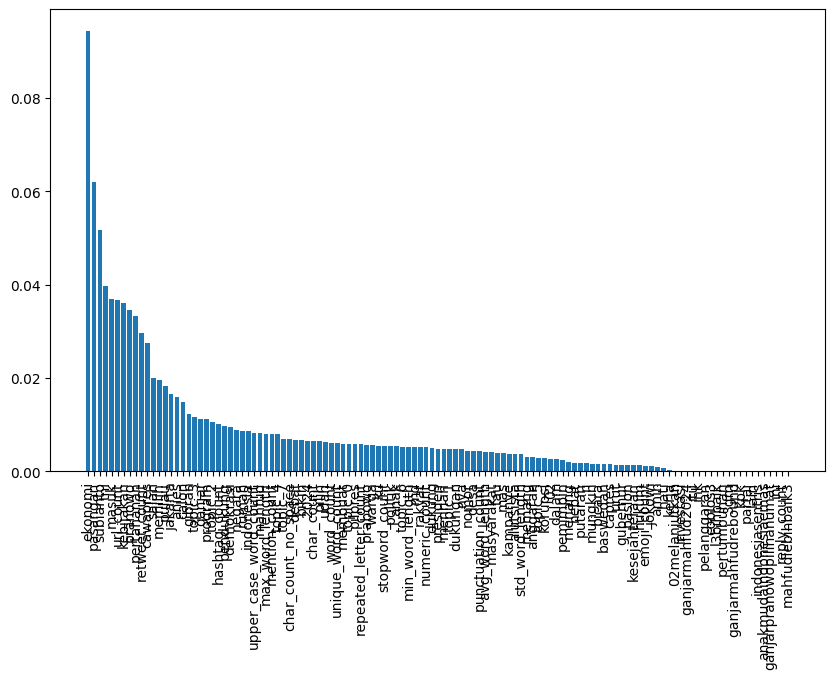

In [41]:
# feature importance
import matplotlib.pyplot as plt

importances = clf.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()


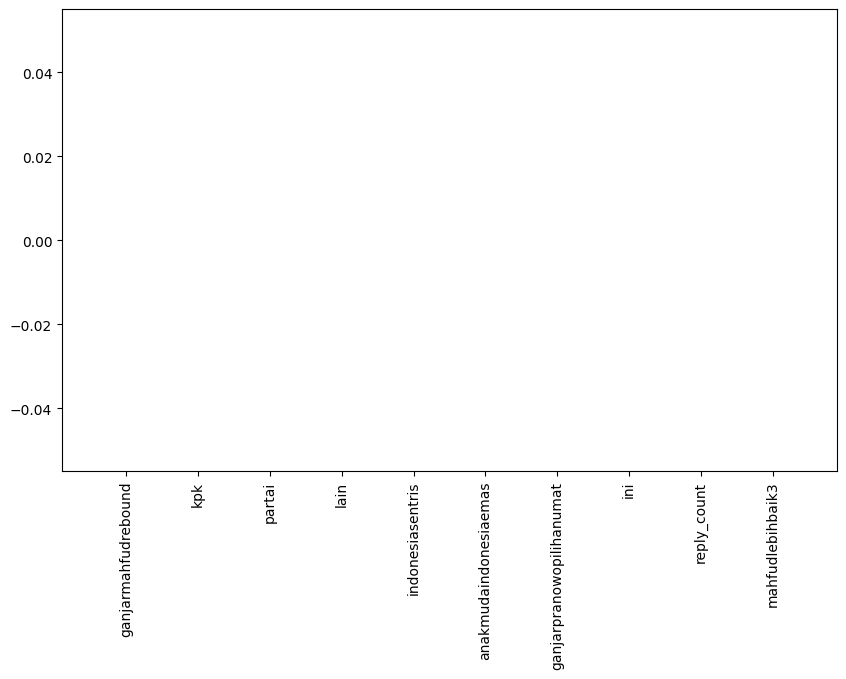

In [42]:
# plot 10 fitur terbawah
plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[indices][-10:])
plt.xticks(range(10), X.columns[indices][-10:], rotation=90)
plt.show()


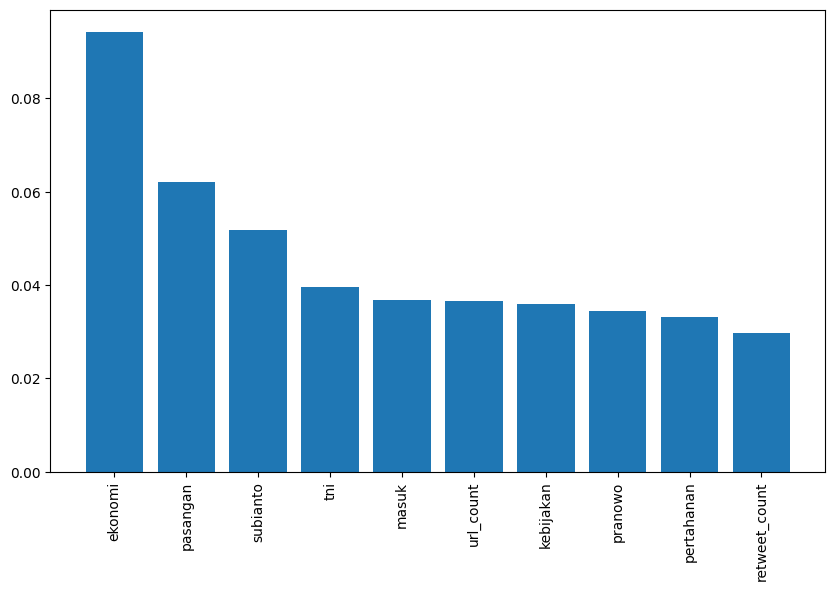

In [43]:
# 10 fitur teratas
importances = clf.feature_importances_
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[indices][:10])
plt.xticks(range(10), X.columns[indices][:10], rotation=90)



plt.show()

In [44]:
unlabeled = pd.read_excel('../data/cleaned_unlabeled_dataset_2.xlsx')
unlabeled.rename(columns={'Text': 'text'}, inplace=True)
unlabeled

,IDText,text,clean_text
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,org2 pro-demokrasi negara kesempatan ngelawan ...
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,prabowo ditanya hutang negeri menjawab hutang ...
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,kiki_daliyo ganjar pranowo sosok mengagunhkan ...
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,prabowo gibran melakukan kesejahteraan rakyat
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,nyambung junjungan elu aomkmkmkmk ngomongin et...
...,...,...,...
995,TXT0996,"Bikin bangga deh, Ganjar-Mahfud mau alokasikan...","bikin bangga deh, ganjar-mahfud alokasikan bel..."
996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,jokowi pilpres 2024 berbesar hati merangkul pr...
997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...,sbaiknya si gemot nga ikutan debat deh..nga ma...
998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...,kebiasaan merembuk bermusyawarah gaya kepemimp...


# INFERENCE

In [45]:
unlabeled = get_character_features(unlabeled)

In [46]:
unlabeled

,IDText,text,clean_text,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,paslon,bicara,l3bihbaik,ganjarmahfudrebound,nomor,kpk,ri,nya,ku,pulau
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,org2 pro-demokrasi negara kesempatan ngelawan ...,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,prabowo ditanya hutang negeri menjawab hutang ...,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,kiki_daliyo ganjar pranowo sosok mengagunhkan ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,prabowo gibran melakukan kesejahteraan rakyat,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,nyambung junjungan elu aomkmkmkmk ngomongin et...,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,TXT0996,"Bikin bangga deh, Ganjar-Mahfud mau alokasikan...","bikin bangga deh, ganjar-mahfud alokasikan bel...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,jokowi pilpres 2024 berbesar hati merangkul pr...,0,1,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,0
997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...,sbaiknya si gemot nga ikutan debat deh..nga ma...,3,1,1,1,0,2,1,...,0,0,0,0,0,0,0,0,0,0
998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...,kebiasaan merembuk bermusyawarah gaya kepemimp...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# predict
X_unlabeled = unlabeled.drop(columns=['text', 'clean_text', 'IDText'])
y_unlabeled = clf.predict(X_unlabeled)

unlabeled['label'] = y_unlabeled
unlabeled

,IDText,text,clean_text,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,bicara,l3bihbaik,ganjarmahfudrebound,nomor,kpk,ri,nya,ku,pulau,label
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,org2 pro-demokrasi negara kesempatan ngelawan ...,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,5
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,prabowo ditanya hutang negeri menjawab hutang ...,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,kiki_daliyo ganjar pranowo sosok mengagunhkan ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,prabowo gibran melakukan kesejahteraan rakyat,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,7
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,nyambung junjungan elu aomkmkmkmk ngomongin et...,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,TXT0996,"Bikin bangga deh, Ganjar-Mahfud mau alokasikan...","bikin bangga deh, ganjar-mahfud alokasikan bel...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,jokowi pilpres 2024 berbesar hati merangkul pr...,0,1,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,5
997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...,sbaiknya si gemot nga ikutan debat deh..nga ma...,3,1,1,1,0,2,1,...,0,0,0,0,0,0,0,0,0,7
998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...,kebiasaan merembuk bermusyawarah gaya kepemimp...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [48]:
# kembalikan label ke string
unlabeled['label'] = le.inverse_transform(y_unlabeled)
unlabeled

,IDText,text,clean_text,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,bicara,l3bihbaik,ganjarmahfudrebound,nomor,kpk,ri,nya,ku,pulau,label
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,org2 pro-demokrasi negara kesempatan ngelawan ...,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Politik
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,prabowo ditanya hutang negeri menjawab hutang ...,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Pertahanan dan Keamanan
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,kiki_daliyo ganjar pranowo sosok mengagunhkan ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ideologi
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,prabowo gibran melakukan kesejahteraan rakyat,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,Sumber Daya Alam
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,nyambung junjungan elu aomkmkmkmk ngomongin et...,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ekonomi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,TXT0996,"Bikin bangga deh, Ganjar-Mahfud mau alokasikan...","bikin bangga deh, ganjar-mahfud alokasikan bel...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Politik
996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,jokowi pilpres 2024 berbesar hati merangkul pr...,0,1,0,2,0,1,1,...,0,0,0,0,0,0,0,0,0,Politik
997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...,sbaiknya si gemot nga ikutan debat deh..nga ma...,3,1,1,1,0,2,1,...,0,0,0,0,0,0,0,0,0,Sumber Daya Alam
998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...,kebiasaan merembuk bermusyawarah gaya kepemimp...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ekonomi


In [49]:

# hapus kolom fitur
unlabeled.drop(columns=X_unlabeled.columns, inplace=True)

unlabeled.drop(columns='clean_text', inplace=True)
# simpan ke file
unlabeled.to_excel('../output/predicted_unlabeled_dataset.xlsx', index=False)


In [50]:
unlabeled

,IDText,text,label
0,TXT0001,Lu mau org2 pro-demokrasi di negara ini bisa p...,Politik
1,TXT0002,Prabowo ditanya soal hutang luar negeri dia me...,Pertahanan dan Keamanan
2,TXT0003,kiki_daliyo Ganjar Pranowo itulah beliau soso...,Ideologi
3,TXT0004,@kumparan Prabowo Gibran yang bisa melakukan i...,Sumber Daya Alam
4,TXT0005,@sniperruben45 @uda_zulhendra @ainunnajib Lah ...,Ekonomi
...,...,...,...
995,TXT0996,"Bikin bangga deh, Ganjar-Mahfud mau alokasikan...",Politik
996,TXT0997,Pak Jokowi sebelum pilpres 2024 berbesar hati ...,Politik
997,TXT0998,@datuakrajoangek Sbaiknya si gemot nga usah ik...,Sumber Daya Alam
998,TXT0999,kebiasaan merembuk atau bermusyawarah jadi gay...,Ekonomi


In [51]:
#simpan Idteks dan label ubah nama jadi kelas lalu simpan ke csv
unlabeled.rename(columns={'IDText': 'IDText', 'label': 'Kelas'}, inplace=True)
unlabeled.to_csv('../output/predicted_unlabeled_dataset_2.csv', index=False)

unlabeled.drop(columns='text', inplace=True)
unlabeled.to_csv('../output/predicted_formatted_2.csv', index=False)

predicted = pd.read_csv('../output/predicted_formatted_2.csv')
predicted

,IDText,Kelas
0,TXT0001,Politik
1,TXT0002,Pertahanan dan Keamanan
2,TXT0003,Ideologi
3,TXT0004,Sumber Daya Alam
4,TXT0005,Ekonomi
...,...,...
995,TXT0996,Politik
996,TXT0997,Politik
997,TXT0998,Sumber Daya Alam
998,TXT0999,Ekonomi
